In [1]:
from dynamics import *
from problem import *
import numpy as np
from casadi import *
import casadi as cs
import matplotlib.pyplot as plt
import seaborn as sns
from util import *
import itertools 
from time import perf_counter

In [2]:
from decentralized import util

In [3]:
%load_ext autoreload
%autoreload 2

## An example of using Casadi to optimize trajectory for a single quadrotor:

In [31]:
# x0 = np.random.rand(6*3,1)
x0 = np.array([0.1, 0.1, 1.0, 0.1, 0.1, 0.1])
xf = np.array([1.2, 1.2, 1.8, 0, 0, 0])
Q = np.diag([5,5,5,1,1,1])
R = np.eye(3)*0.01
Qf = np.eye(6)*1000
g = 9.8

u_ref = np.array([0,0,g])
N = 100

opti = Opti()

dt = 0.05

In [32]:
# models = [quad6D,quad6D,quad6D]

In [33]:
# ids = [i for i in range(n_agents)]

In [34]:
# quad6D(xf,Q,R,Qf,u_ref,N).cost()

In [35]:
# dynamics = MultiDynamicalModel([model(split_agents(xf.T,x_dims)[id_],Q,R,Qf,split_agents(u_ref.T,u_dims)[id_],N) for model,id_ in zip(models,ids)])

In [36]:
# problem = quadProblem()

In [37]:
X = opti.variable(6,N+1)
U = opti.variable(3,N)

In [38]:
# x_dims = [6,6,6,6]

In [39]:
g = 9.81

In [40]:
f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g) #dx/dt = f(x,u)

In [14]:
for k in range(N): #loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

    opti.subject_to(X[:,k+1]==x_next) # close the gaps


In [15]:
total_stage_cost = 0
for j in range(X.shape[1]-1):
    for i in range(X.shape[0]):
        total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

for j in range(U.shape[1]-1):
    for i in range(U.shape[0]):
        total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

#Quadratic terminal cost:
total_terminal_cost = 0
# for j in range(X.shape[1]):
for i in range(X.shape[0]):
    total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])

In [16]:
objective = total_terminal_cost + total_stage_cost
# objective = total_stage_cost


In [17]:
opti.minimize(objective) 

In [18]:
opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
opti.subject_to(0.4<=X[2,:])

opti.subject_to(X[0,:]<=3) # p_x is limited
opti.subject_to(-3<=X[0,:])

opti.subject_to(X[1,:]<=3) # p_y is limited
opti.subject_to(-3<=X[1,:])

opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
opti.subject_to(-np.pi/6<=U[0,:])

opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
opti.subject_to(-np.pi/6<=U[1,:])

opti.subject_to(U[2,:]<=25) # tau is limited
opti.subject_to(0<=U[2,:]) #minimum force 

# opti.subject_to(X[0:3,-1] == xf[0:3])
#equality constraints:
opti.subject_to(X[:,0] == x0)
t0 = perf_counter()
opti.solver("ipopt")
sol = opti.solve()
tf = perf_counter()

print(f'total run time is {tf-t0} seconds')



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2106
Number of nonzeros in inequality constraint Jacobian.:     1206
Number of nonzeros in Lagrangian Hessian.............:      905

Total number of variables............................:      906
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality co

In [19]:
X_trj = sol.value(X)
U_trj = sol.value(U)

In [20]:
U_trj.shape

(3, 100)

Text(0.5, 0.92, 'Trajectory from one-shot optimization')

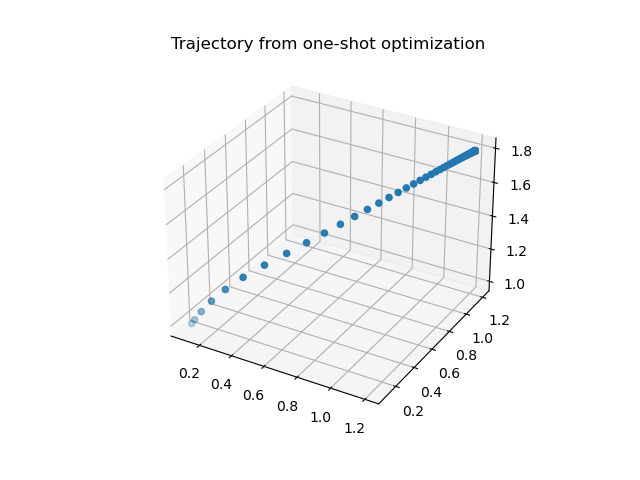

In [23]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_trj[0,:],X_trj[1,:],X_trj[2,:])
ax.set_title('Trajectory from one-shot optimization')


In [24]:
pos_err = np.linalg.norm(X_trj[0:3,-1]-xf[0:3])
pos_err

5.2727072380359054e-06

## Running the above optimizaiton but in a receding-horizon fashion:
In this case, we relax the terminal state constraint and impose a terminal state cost into the objective function. The reason is that each optimization step is solved over a control horizon, and it's not possible that the drone reaches its goal after each control horizon (which keeps shifting forward)

In [4]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1):
        for i in range(X.shape[0]):
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]-1):
        for i in range(U.shape[0]):
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost
    # return total_stage_cost

In [5]:
x0 = np.array([0.5, 0.5, 1.0, 0.0, 0.0, 0.0])
xf = np.array([1.3, 1.1, 1.8, 0, 0, 0])
Q = np.diag([5,5,5,1,1,1])
R = np.eye(3)*0.01
Qf = np.eye(6)*1000

# u_ref = np.zeros((3,1))
u_ref = np.array([0,0,9.8])

In [6]:
n_agents = 1
n_states = 6
n_inputs=  3

In [7]:
def solve_rhc(x0,xf,u_ref,N,Qf):
    #N is the shifting prediction horizon
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 100,"print_level":4}
    
    opti = Opti()
    M = 100 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    
    f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g) #dx/dt = f(x,u)
    
    dt = 0.05
    
    while (np.linalg.norm(x0[0:3]-xf[0:3]) > 0.1) and (i < M):
    
        X = opti.variable(6,N+1)
        U = opti.variable(3,N)
        
        cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)
        
        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps

        opti.subject_to(X[2,:]<=3.0) # altitude p_z is limited
        opti.subject_to(0.4<=X[2,:])

        opti.subject_to(X[0,:]<=3) # p_x is limited
        opti.subject_to(-3<=X[0,:])

        opti.subject_to(X[1,:]<=3) # p_y is limited
        opti.subject_to(-3<=X[1,:])
        
        opti.subject_to(X[3,:] <=5) #Vx is limited
        opti.subject_to(0 <= X[3,:])
        
        opti.subject_to(X[4,:] <=5) #Vy is limited
        opti.subject_to(0 <= X[4,:])
        
        opti.subject_to(X[5,:] <=5) #Vz is limited
        opti.subject_to(0 <= X[5,:])

        opti.subject_to(U[0,:]<=np.pi/6) # theta is limited
        opti.subject_to(-np.pi/6<=U[0,:])

        opti.subject_to(U[1,:]<=np.pi/6) # phi is limited
        opti.subject_to(-np.pi/6<=U[1,:])

        opti.subject_to(U[2,:]<=20) # tau is limited
        opti.subject_to(0<=U[2,:]) #minimum force keeps the drone at hover

        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)

        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        
        sol = opti.solve()
        x0 = sol.value(X)[:,1]
        u_sol = sol.value(U)[:,0]
        J_list.append(sol.value(cost_fun))
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        if abs(J_list[i]-J_list[i-1]) <= 10 :
            print(f'Terminated! at i = {i}')
            break
        
        
    return X_full,U_full, t
    

In [8]:
from time import perf_counter

In [9]:
N = 5
t0 = perf_counter()
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Qf)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:       51
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       36
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       51


Number of Iterations....: 13

     

In [10]:
x_trj.shape

(13, 6)

Text(0.5, 0.92, 'Trajectory with receding horizon')

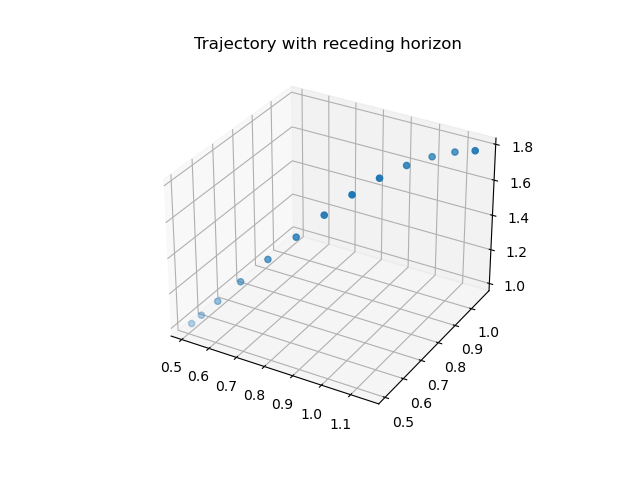

In [11]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x_trj[:,0],x_trj[:,1],x_trj[:,2])
ax.set_title('Trajectory with receding horizon')

In [14]:
pos_err = np.linalg.norm(x_trj[-1,0:3]-xf[0:3])

In [15]:
pos_err  #not bad!


0.15617746409589622

## Running 3 drones in a centralized fashion:

In [41]:
x0,xf = paper_setup_3_quads()

In [42]:
xf.shape

(18, 1)

In [43]:
g = 9.81

In [44]:
n_agents = 3
n_states = 6
n_inputs=  3


# Qs = [Q] * n_agents
# Rs = [R] * n_agents
# Qfs = [Qf] * n_agents
# x_dims = [n_states]*n_agents
# u_dims = [n_inputs]*n_agents

In [45]:
u_ref = np.array([0, 0, g, 0, 0, g, 0, 0, g])
Q = np.diag([5,5,5,1,1,1,5,5,5,1,1,1,5,5,5,1,1,1])
R = np.eye(n_agents*n_inputs)*0.01
Qf = np.eye(n_agents*n_states)*1000

theta_max = np.pi/6
phi_max = np.pi/6

v_max = 3
v_min = -3

theta_min = -np.pi/6
phi_min = -np.pi/6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.0

In [46]:
max_input = np.array([[theta_max], [phi_max], [tau_max], \
                          [theta_max], [phi_max], [tau_max], \
                          [theta_max], [phi_max], [tau_max]])

min_input = np.array([[theta_min], [phi_min], [tau_min], \
                      [theta_min], [phi_min], [tau_min], \
                      [theta_min], [phi_min], [tau_min]])

max_state_upper = np.array([[x_max], [y_max], [z_max], [v_max],[v_max], [v_max],\
                          [x_max], [y_max], [z_max], [v_max],[v_max], [v_max],\
                          [x_max], [y_max], [z_max], [v_max],[v_max], [v_max]])
    
max_state_lower = np.array([[x_min], [y_min], [z_min], [v_min],[v_min], [v_min],\
                          [x_min], [y_min], [z_min], [v_min],[v_min], [v_min],\
                          [x_min], [y_min], [z_min], [v_min],[v_min], [v_min]])

In [47]:
max_input.shape

(9, 1)

In [48]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1):
        for i in range(X.shape[0]):
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]):
        for i in range(U.shape[0]):
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost

In [49]:
eps = 1e-3

In [50]:
f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                        x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                        x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g) #dx/dt = f(x,u)

In [80]:
def solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states):
    #N is the shifting prediction horizon
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 150,"print_level":0}
    
    
    M = 150 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    x_dims = [n_states]*n_agents
    
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    dt = 0.05
    
    while np.any(distance_to_goal(x0,xf,n_agents,n_states) > 0.1)  and (i < M):
        
        
        opti = Opti()
        
        X = opti.variable(n_x,N+1)
        U = opti.variable(n_u,N)
        
        cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)
        
        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps
            
            #Constraints on inputs:
            for j in range(max_input.shape[0]):
                # print(U[j,k].shape,max_input[j].shape)
                opti.subject_to(U[j,k] <= max_input[j] )
                opti.subject_to(min_input[j] <= U[j,k] )
                
        #Hard-coding collision avoidance constraints:
        # for k in range(N+1):    
        #     #Collision avoidance:
        #     opti.subject_to(-sqrt((X[0,k]-X[6,k])**2+ (X[1,k]-X[7,k])**2 +(X[2,k]-X[8,k])**2 + eps)  <= -0.5)
        #     opti.subject_to(-sqrt((X[0,k]-X[12,k])**2 +(X[1,k]-X[13,k])**2 +(X[2,k]-X[14,k])**2 + eps) <= -0.5)
        #     opti.subject_to(-sqrt((X[12,k]-X[6,k])**2 +(X[13,k]-X[7,k])**2 +(X[14,k]-X[8,k])**2 + eps) <= -0.5)
        
        #collision avoidance
        for k in range(N+1):
            distances = compute_pairwise_distance_Sym(X[:,k], x_dims)
            for n in range(len(distances)):
                opti.subject_to(distances[n] >= 0.5)
                
            #constraints on states:
            for m in range(max_state_lower.shape[0]):

                opti.subject_to(X[m,k]<= max_state_upper[m] )
                opti.subject_to(max_state_lower[m] <= X[m,k])

            
        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)
        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        
        sol = opti.solve()
        # print(opti.debug.value)
        x0 = sol.value(X)[:,1].reshape(-1,1)
        # print(x0.shape)
        u_sol = sol.value(U)[:,0]
        
        J_list.append(sol.value(cost_fun))
        print(f'current objective function value is {sol.value(cost_fun)}')
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        # print(opti.variable) #print this to check the optimization parameters for each control horizon
        
        if abs(J_list[i]-J_list[i-1]) <= 1.0 :
            print(f'Terminated! at i = {i}')
            break
            
        
    return X_full,U_full, t

In [81]:
N = 15
t0 = perf_counter()
n_agents =3
n_states=6
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 260.10us (  7.22us)        36
       nlp_g  |        0 (       0) 847.00us ( 23.53us)        36
  nlp_grad_f  |        0 (       0) 339.30us (  9.98us)        34
  nlp_hess_l  |        0 (       0)   1.15ms ( 35.82us)        32
   nlp_jac_g  |        0 (       0)   1.21ms ( 35.64us)        34
       total  | 218.75ms (218.75ms) 213.53ms (213.53ms)         1
(18, 1)
current objective function value is 3208.3983588182737
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 388.80us (  9.97us)        39
       nlp_g  |  15.62ms (400.64us) 933.90us ( 23.95us)        39
  nlp_grad_f  |        0 (       0) 360.20us (  9.48us)        38
  nlp_hess_l  |        0 (       0)   1.41ms ( 39.14us)        36
   nlp_jac_g  |        0 (       0)   1.39ms ( 36.57us)        38
       total  | 250.00ms (250.00ms) 243.97ms (243.97ms)         1
(18, 1)
curre

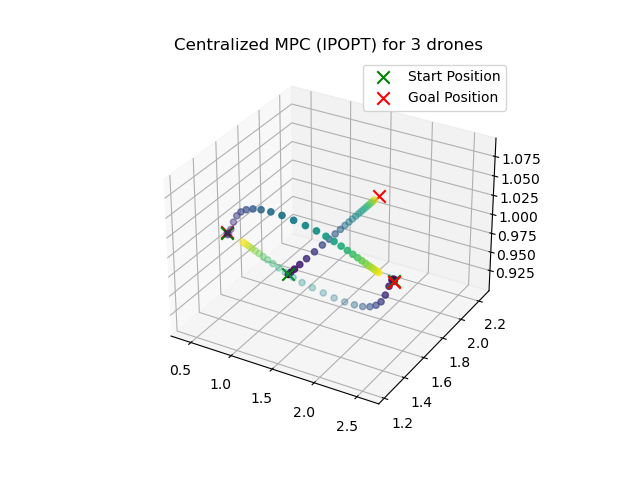

In [82]:
plt.figure()
util.plot_solve(x_trj,6.2, xf, [6,6,6], n_d=3)
plt.title('Centralized MPC (IPOPT) for 3 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);
plt.savefig('results/Centralized MPC (IPOPT) for 3 drones.png')

In [83]:
#5 drones:
x0 = np.array([[-0.182, -0.545,  1.161,  0.   ,  0.   ,  0.   ,  1.335,  1.484,
         0.5  ,  0.   ,  0.   ,  0.   , -0.97 , -0.831,  2.295,  0.   ,
         0.   ,  0.   , -1.144, -1.193,  1.7  ,  0.   ,  0.   ,  0.   ,
         0.961,  1.085,  0.88 ,  0.   ,  0.   ,  0.   ]]).T

xf = np.array([[-1.751,  0.674, -1.193,  0.   ,  0.   ,  0.   ,  1.769,  0.102,
         2.998,  0.   ,  0.   ,  0.   , -1.452, -0.02 , -1.11 ,  0.   ,
         0.   ,  0.   ,  0.34 , -0.993, -0.832,  0.   ,  0.   ,  0.   ,
         1.094,  0.237,  0.137,  0.   ,  0.   ,  0.   ]]).T

u_ref = np.array([0,0,g,0,0,g,0,0,g,0,0,g,0,0,g])

n_agents = 5
n_states = 6
n_inputs=  3
Q = np.diag([5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1,\
             5,5,5,1,1,1])
R = np.eye(n_agents*n_inputs)*0.01
Qf = np.eye(n_agents*n_states)*1000

theta_max = np.pi/6
phi_max = np.pi/6

v_max = 3
v_min = -3

theta_min = -np.pi/6
phi_min = -np.pi/6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.0

In [84]:
max_input_base = np.array([[theta_max], [phi_max], [tau_max]])
min_input_base = np.array([[theta_min], [phi_min], [tau_min]])
max_state_base = np.array([[x_max], [y_max], [z_max], [v_max],[v_max], [v_max]])
min_state_base = np.array([[x_min], [y_min], [z_min], [v_min],[v_min], [v_min]])

In [85]:
max_input = np.tile(max_input_base,5)
min_input = np.tile(min_input_base,5)

max_state = np.tile(max_state_base,5)
min_state = np.tile(min_state_base,5)

In [86]:
def generate_f(x_dims_local):
    
    # NOTE: Assume homogeneity of agents.
    n_agents = len(x_dims_local)
    n_states = x_dims_local[0] // n_agents
    n_controls = 3
    
    def f(x, u):
        x_dot = cs.MX.zeros(x.numel())
        for i_agent in range(n_agents):
            i_xstart = i_agent * n_states
            i_ustart = i_agent * n_controls
            x_dot[i_xstart:i_xstart + n_states] = cs.vertcat(
                x[i_xstart + 3: i_xstart + 6],
                g*cs.tan(u[i_ustart]), -g*cs.tan(u[i_ustart+1]), u[i_ustart+2] - g
                )
            
        return x_dot
    
    return f    

In [87]:
# f = generate_f([6,6,6,6,6])

In [88]:
x0.shape

(30, 1)

In [89]:
f = lambda x,u: vertcat(x[3],x[4],x[5],  g*tan(u[0]), -g*tan(u[1]),u[2]-g,
                        x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]), u[5]-g,
                        x[15],x[16],x[17], g*tan(u[6]), -g*tan(u[7]), u[8]-g,
                        x[21],x[22],x[23], g*tan(u[9]), -g*tan(u[10]), u[11]-g,
                        x[27],x[28],x[29], g*tan(u[12]), -g*tan(u[13]), u[14]-g) #dx/dt = f(x,u)

In [91]:
N = 15
t0 = perf_counter()
print(x0.shape,xf.shape)
x_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

(30, 1) (30, 1)
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)   1.04ms ( 10.33us)       101
       nlp_g  |        0 (       0)   4.10ms ( 40.55us)       101
  nlp_grad_f  |        0 (       0)   1.19ms ( 15.43us)        77
  nlp_hess_l  |        0 (       0)   6.03ms ( 75.32us)        80
   nlp_jac_g  |        0 (       0)   5.27ms ( 62.76us)        84
       total  |   5.50 s (  5.50 s) 967.73ms (967.73ms)         1
(30, 1)
current objective function value is 6539.473362437575
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)   1.16ms ( 10.66us)       109
       nlp_g  |        0 (       0)   4.45ms ( 40.81us)       109
  nlp_grad_f  |        0 (       0)   1.52ms ( 14.91us)       102
  nlp_hess_l  |        0 (       0)   7.71ms ( 75.54us)       102
   nlp_jac_g  | 187.50ms (  1.77ms)   6.89ms ( 64.97us)       106
       total  |   6.64 s (  6.64 s)   1.22 s (  1.22 s)         

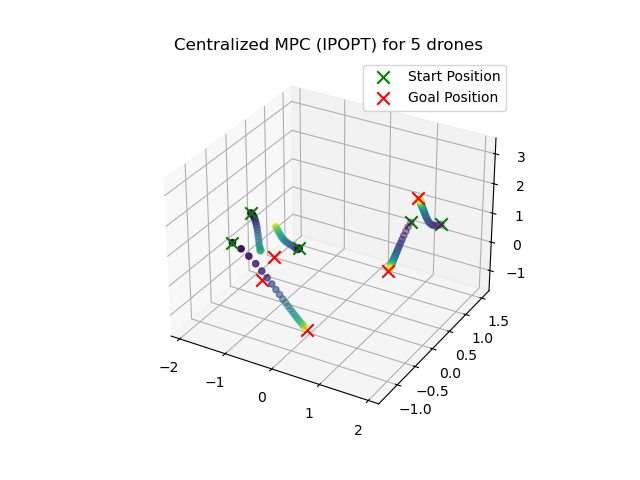

In [92]:
plt.figure()
util.plot_solve(x_trj, 2857, xf, [6,6,6,6,6], n_d=3)
plt.title('Centralized MPC (IPOPT) for 5 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);
plt.savefig('results/Centralized MPC (IPOPT) for 5 drones.png')

## Todo: run the centralized MPC above for up to 10 drones:

## Now run the above optimization problem in distributed fashion using game-potential formulation:

In [10]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1):
        for i in range(X.shape[0]):
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]):
        for i in range(U.shape[0]):
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost

In [11]:
def generate_min_max_input(inputs_dict,n_inputs):
    
    theta_max = np.pi/6
    phi_max = np.pi/6

    v_max = 3
    v_min = -3

    theta_min = -np.pi/6
    phi_min = -np.pi/6

    tau_max = 15
    tau_min = 0
    
    n_agents = [u.shape[0] // n_inputs for u in inputs_dict.values()]

    u_min = np.array([[theta_min, phi_min, tau_min]])
    u_max = np.array([[theta_max, phi_max, tau_max]])
    
    return [
        (np.tile(u_min, n_agents_i), np.tile(u_max, n_agents_i)) 
        for n_agents_i in n_agents
        ]

  

In [12]:
def generate_min_max_state(states_dict,n_states):
    
    x_min = -5
    x_max = 5

    y_min = -5
    y_max = 5

    z_min = 0
    z_max = 3.0
    
    n_agents = [x.shape[0] // n_states for x in states_dict.values()]
    x_min = np.array([[x_min, y_min, z_min, v_min, v_min , v_min]])
    x_max = np.array([[x_max, y_max, z_max, v_max, v_max, v_max]])
    
    return [
        (np.tile(x_min, n_agents_i), np.tile(x_max, n_agents_i)) 
        for n_agents_i in n_agents
        ]

  

In [29]:
u_ref = np.array([0, 0, g, 0, 0, g, 0, 0, g])
Q = np.diag([5,5,5,1,1,1,5,5,5,1,1,1,5,5,5,1,1,1])
R = np.eye(n_agents*n_inputs)*0.01
Qf = np.eye(n_agents*n_states)*1000

theta_max = np.pi/6
phi_max = np.pi/6

v_max = 3
v_min = -3

theta_min = -np.pi/6
phi_min = -np.pi/6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.0

x0,xf = paper_setup_3_quads()
n_agents = 3
n_states=6
n_inputs=3
x_dims = [n_states]*n_agents
u_dims = [n_inputs]*n_agents
radius=0.5
ids = [100 + i for i in range(n_agents)]

In [30]:
def generate_f(x_dims_local):
    
    # NOTE: Assume homogeneity of agents.
    n_agents = len(x_dims_local)
    n_states = x_dims_local[0] // n_agents
    n_controls = 3
    
    def f(x, u):
        x_dot = cs.MX.zeros(x.numel())
        for i_agent in range(n_agents):
            i_xstart = i_agent * n_states
            i_ustart = i_agent * n_controls
            x_dot[i_xstart:i_xstart + n_states] = cs.vertcat(
                x[i_xstart + 3: i_xstart + 6],
                g*cs.tan(u[i_ustart]), -g*cs.tan(u[i_ustart+1]), u[i_ustart+2] - g
                )
            
        return x_dot
    
    return f    

In [32]:
N=10

In [35]:
rel_dists = compute_pairwise_distance(x0*0.1, x_dims, n_d=3)
"""ERROR HERE: GRAPH IS NOT CORRECT AFTER 0th ITERATION:"""
graph = define_inter_graph_threshold(x0*0.1, radius, x_dims, ids) 
print(graph,rel_dists)
#x0 is updated until convergence (treat x0 as the combined CURRENT state)

#break up the problem into potential-game sub-problems at every outer iteration
split_problem_states_initial = split_graph(x0.T*0.1,x_dims,graph)
split_problem_states = split_graph(xf.T*0.1,x_dims,graph)
split_problem_inputs = split_graph(u_ref.reshape(-1,1).T,u_dims,graph)
d = {}
states = {}
inputs = {}
cost_fun_list = [] 

d = {} #dictionary holding Opti() objects (or subproblems)
states = {} #dictionary holding symbolic state trajectory for each sub-problem
inputs = {} ##dictionary holding symbolic input trajectory for each sub-problem

for i,j in enumerate(split_problem_states_initial):
    d['opti_{0}'.format(i)] = Opti()
    states['X_{0}'.format(i)] = d[f'opti_{i}'].variable(j.shape[1],N+1) 

for i,j in enumerate(split_problem_inputs):
    inputs['U_{0}'.format(i)] = d[f'opti_{i}'].variable(j.shape[1],N)

#Storing objective functions for each sub-problem into a list:
for i in range(len(split_problem_states)):
    cost_fun_list.append(objective(states[f'X_{i}'],\
                           inputs[f'U_{i}'],\
                           split_problem_inputs[i].reshape(-1,),\
                           split_problem_states[i].reshape(-1,1),\
                           np.eye(split_problem_states[i].shape[1]),
                           np.eye(split_problem_inputs[i].reshape(-1,).shape[0])*0.1,
                           np.eye(split_problem_states[i].shape[1])*1000))

min_max_input_list = generate_min_max_input(inputs,n_inputs)
min_max_state_list = generate_min_max_state(states,n_states)


{100: [100, 101, 102], 101: [100, 101, 102], 102: [100, 101, 102]} [[0.2   0.102 0.102]]


In [24]:
objective_val = 0
        
for di, statesi, inputsi, costi, state_boundsi, input_boundsi, (prob,ids), count in zip(
    d.values(), 
    states.values(), 
    inputs.values(), 
    cost_fun_list, 
    min_max_state_list,
    min_max_input_list,
    graph.items(),
    range(len(d))): #loop over sub-problems
    print(statesi.shape[0])
    print(ids.index(prob))

NameError: name 'd' is not defined

In [36]:
def solve_rhc_distributed(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius, ids):

    x_dims = [n_states]*n_agents
    u_dims = [n_inputs]*n_agents
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 150,"print_level":0}
    
    M = 100 # this is the entire fixed horizon
    
    n_x = n_agents*n_states
    n_u = n_agents*n_inputs
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    loop = 0
    dt = 0.1
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    
    while np.any(distance_to_goal(x0,xf,n_agents,n_states) > 0.1) and (loop < M):
        # print(f'dis to goal is {distance_to_goal(x0,xf,n_agents,n_states)}')
        ######################################################################
        #Determine sub problems to solve:
        
        #compute interaction graph at the current time step:
        print(x0.T)
        rel_dists = compute_pairwise_distance(x0, x_dims, n_d=3)
        """ERROR HERE: GRAPH IS NOT CORRECT AFTER 0th ITERATION:"""
        graph = define_inter_graph_threshold(x0, radius, x_dims, ids) 
        print(graph,rel_dists)
        #x0 is updated until convergence (treat x0 as the combined CURRENT state)
        
        #break up the problem into potential-game sub-problems at every outer iteration
        split_problem_states_initial = split_graph(x0.T,x_dims,graph)
        split_problem_states = split_graph(xf.T,x_dims,graph)
        split_problem_inputs = split_graph(u_ref.reshape(-1,1).T,u_dims,graph)
        
        #Initiate different instances of Opti() object
        #Each Opti() object corresponds to a subproblem (there is NO central node)
        #Note that when 2 agents are combined into a single problem, we have 2 copies of the same sub problem
        ########################################################################
        #Setting up the solvers:
        d = {}
        states = {}
        inputs = {}
        cost_fun_list = [] 
        
        d = {} #dictionary holding Opti() objects (or subproblems)
        states = {} #dictionary holding symbolic state trajectory for each sub-problem
        inputs = {} ##dictionary holding symbolic input trajectory for each sub-problem
        
        for i,j in enumerate(split_problem_states_initial):
            d['opti_{0}'.format(i)] = Opti()
            states['X_{0}'.format(i)] = d[f'opti_{i}'].variable(j.shape[1],N+1) 

        for i,j in enumerate(split_problem_inputs):
            inputs['U_{0}'.format(i)] = d[f'opti_{i}'].variable(j.shape[1],N)
        
        #Storing objective functions for each sub-problem into a list:
        for i in range(len(split_problem_states)):
            cost_fun_list.append(objective(states[f'X_{i}'],\
                                   inputs[f'U_{i}'],\
                                   split_problem_inputs[i].reshape(-1,),\
                                   split_problem_states[i].reshape(-1,1),\
                                   np.eye(split_problem_states[i].shape[1]),
                                   np.eye(split_problem_inputs[i].reshape(-1,).shape[0])*0.1,
                                   np.eye(split_problem_states[i].shape[1])*1000))
        
        min_max_input_list = generate_min_max_input(inputs,n_inputs)
        min_max_state_list = generate_min_max_state(states,n_states)
        
        ##########################################################################
        #Solve each sub-problem in a sequential manner:
        #TODO: parallel computation for better speed?
        
        
        
        objective_val = 0
        
        for di, statesi, inputsi, costi, state_boundsi, input_boundsi, (prob,ids), count in zip(
            d.values(), 
            states.values(), 
            inputs.values(), 
            cost_fun_list, 
            min_max_state_list,
            min_max_input_list,
            graph.items(),
            range(len(d))): #loop over sub-problems
            
      
            print(f'Solving the {count}th sub-problem at iteration {loop}, t = {t}')
            
            # print(prob,ids)
            # print(statesi.shape)
            min_states, max_states = state_boundsi
            min_inputs, max_inputs = input_boundsi
            
            di.minimize(costi)

            n_states_local = statesi.shape[0] #each subproblem has different number of states
            print(f'n_states_local:{n_states_local}')
            n_inputs_local = inputsi.shape[0]
            x_dims_local = [int(n_states)]*int(n_states_local/n_states)
            print(x_dims_local)
            # u_dims_local =  [int(n_inputs_local/(n_inputs_local/n_inputs))]*int(n_inputs_local/n_inputs)
            #i.e, [6,6] if the current sub-problem has 2 agents combined, or [6,6,6] if 3 agents are combined

            f = generate_f(x_dims_local)

            for k in range(N): #loop over control intervals
                # Runge-Kutta 4 integration
 
                k1 = f(statesi[:,k],         inputsi[:,k])
                k2 = f(statesi[:,k]+dt/2*k1, inputsi[:,k])
                k3 = f(statesi[:,k]+dt/2*k2, inputsi[:,k])
                k4 = f(statesi[:,k]+dt*k3,   inputsi[:,k])
                x_next = statesi[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
                
                di.subject_to(statesi[:,k+1]==x_next) # close the gaps
                
                di.subject_to(inputsi[:,k] <= max_inputs.T)
                di.subject_to(min_inputs.T <= inputsi[:,k])
            
            for k in range(N+1):
                
                di.subject_to(statesi[:,k] <= max_states.T)
                di.subject_to(min_states.T <= statesi[:,k])
                
                # DBG
                # distances, d_test = compute_pairwise_distance_Sym(statesi[:,k], x_dims_local)
                # print(distances, d_test)
                
                #collision avoidance over control horizon (only if the current sub-problem contains the states of more than 1 agent):

                if len(x_dims_local) !=1:
                    distances= compute_pairwise_distance_Sym(statesi[:,k], x_dims_local)
                    for n in distances:
                        di.subject_to(n >= 0.5)
        
            
            #equality constraints for initial condition:
            di.subject_to(statesi[:,0] == split_problem_states_initial[i].reshape(-1,1))
            
            di.solver("ipopt",p_opts,
                        s_opts) 
            
            
            sol = di.solve()
          
            objective_val += sol.value(costi) 
            
            x0_local = sol.value(statesi)[:,1]

            u_sol_local = sol.value(inputsi)[:,0]


            i_prob = ids.index(prob)

            #SOMETHINS IS WRONG HERE!!!
            # print(graph.items())
            # print(i_prob)
            
            # print(count)
            # print(x0_local.shape)
            # print(i_prob)
            
            X_dec = np.zeros((1, n_x))
            U_dec = np.zeros((1, n_u))
            X_dec[0,:] = x0.reshape(1,-1)
            
            X_dec[:,count*n_states:(count+1)*n_states] = x0_local[i_prob*n_states_local:(i_prob+1)*n_states_local]
            U_dec[:,count*n_inputs:(count+1)*n_inputs] = u_sol_local[i_prob*n_inputs_local:(i_prob+1)*n_inputs_local]
            
        #PROBLEM RIGHT HERE!!! somehow I get a bunch of unexpected zeros at this step (in the current solution x0)

        print(f'current collected solution is {X_dec}')
        
        # print(x0)
        J_list.append(objective_val) #collect aggregate objective function from all sub-problems after each control horizon is over
     
        #Store the trajectory
        
        X_full = np.r_[X_full, X_dec.reshape(1,-1)]
        x0 = X_full[loop,:].reshape(-1,1)
        print(x0.shape)
        print(f'current updated solution is {x0.T}')
        # print(X_full.shape)
        U_full = np.r_[U_full, U_dec.reshape(1,-1)]
        
        t += dt
        loop +=1
        
        if abs(J_list[loop]-J_list[loop-1]) <= 1 :
            print(f'Terminated! at loop = {loop}')
            break
            
    return X_full,U_full, t
    
    

In [48]:
x_try = np.array([[ 5.000e-01],
 [ 1.500e+00],
 [ 1.000e+00],
 [ 0.000e+00],
 [ 0.000e+00],
 [ 0.000e+00],
 [ 2.500e+00],
 [ 1.500e+00],
 [ 1.000e+00],
 [ 0.000e+00],
 [ 0.000e+00],
 [ 0.000e+00],
 [ 1.500e+00],
 [ 1.328e+00],
 [ 1.000e+00],
 [-3.679e-09],
 [ 5.664e-01],
 [ 2.848e-09]])

In [49]:
compute_pairwise_distance(x_try,x_dims)

array([[2.   , 1.015, 1.015]])

In [50]:
graph = define_inter_graph_threshold(x_try, radius, x_dims, ids)


In [51]:
graph

{100: [100], 101: [101], 102: [102]}

In [52]:
for m,n in (graph.items()):
    # print(m,n)
    print(n.index(m))

0
0
0


In [53]:
graph = define_inter_graph_threshold(x0, radius, x_dims, ids)

In [54]:
graph

{100: [100], 101: [101], 102: [102]}

In [45]:
ids = [100 + i for i in range(n_agents)]

In [46]:
N = 15
radius = 0.5

In [47]:
X_full,U_full, t= solve_rhc_distributed(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius, ids)

##The {graph} dictionary only shows the last sub-problem (102) after the first iteration???
# X_full,U_full, t = solve_rhc_distributed(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius, ids)

[[0.5 1.5 1.  0.  0.  0.  2.5 1.5 1.  0.  0.  0.  1.5 1.3 1.  0.  0.  0. ]]
{100: [100], 101: [101], 102: [102]} [[2.   1.02 1.02]]
Solving the 0th sub-problem at iteration 0, t = 0
n_states_local:6
[6]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  80.40us (  4.47us)        18
       nlp_g  |        0 (       0) 210.00us ( 11.67us)        18
  nlp_grad_f  |        0 (       0)  97.70us (  5.14us)        19
  nlp_hess_l  |        0 (       0) 159.50us (  9.38us)        17
   nlp_jac_g  |        0 (       0) 291.30us ( 15.33us)        19
       total  

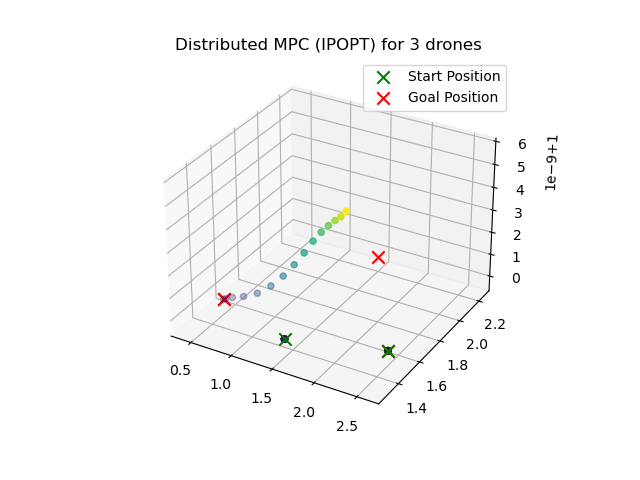

In [303]:
plt.figure()

%matplotlib ipympl
util.plot_solve(X_full, 0, xf, [6,6,6], False, n_d=3)
plt.title('Distributed MPC (IPOPT) for 3 drones');
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"]);
# plt.savefig('results/Distributed MPC (IPOPT) for 3 drones.png')


In [89]:
x0.T

array([[0.5, 1.5, 1. , 0. , 0. , 0. , 2.5, 1.5, 1. , 0. , 0. , 0. , 1.5,
        1.3, 1. , 0. , 0. , 0. ]])

In [90]:
xf.T

array([[2.5, 1.5, 1. , 0. , 0. , 0. , 0.5, 1.5, 1. , 0. , 0. , 0. , 1.5,
        2.2, 1. , 0. , 0. , 0. ]])